# Implementation

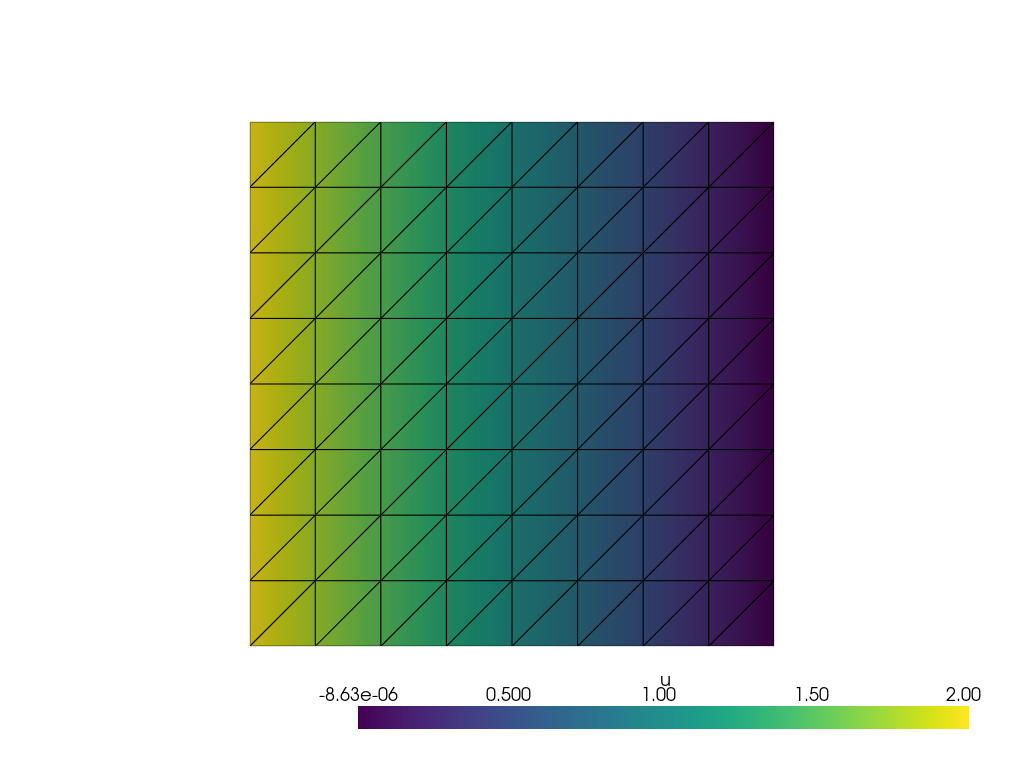

In [2]:
import ufl
from dolfinx import mesh, fem, io, default_scalar_type, plot
from dolfinx.fem.petsc import LinearProblem
from mpi4py import MPI
import numpy as np
import basix
import pyvista
pyvista.set_jupyter_backend('static')

# Mesh
domain = mesh.create_unit_square(
    MPI.COMM_WORLD, 8, 8
)  # coarse to exaggerate oscillations

# Elements
order = 2
V_el = basix.ufl.element("BDM", domain.basix_cell(), order)  # flux q
P_el = basix.ufl.element("DG", domain.basix_cell(), order - 1)  # pressure p
W = fem.functionspace(domain, basix.ufl.mixed_element([V_el, P_el]))

(q, p) = ufl.TrialFunctions(W)
(q_, p_) = ufl.TestFunctions(W)

# Material
kappa = 1e-10  # very low permeability
mu_f = 1.0  # fluid viscosity


# Boundary conditions: pressure on left/right
def left(x):
    return np.isclose(x[0], 0.0)


def right(x):
    return np.isclose(x[0], 1.0)


def top(x):
    return np.isclose(x[1], 1.0)


def bottom(x):
    return np.isclose(x[1], 0.0)


left_facets = mesh.locate_entities_boundary(domain, 1, left)
right_facets = mesh.locate_entities_boundary(domain, 1, right)
top_facets = mesh.locate_entities_boundary(domain, 1, top)
bottom_facets = mesh.locate_entities_boundary(domain, 1, bottom)
Q, _ = W.sub(0).collapse()
top_dofs_q = fem.locate_dofs_topological((W.sub(0), Q), 1, top_facets)
bottom_dofs_q = fem.locate_dofs_topological((W.sub(0), Q), 1, bottom_facets)

bc_top = fem.dirichletbc(fem.Function(Q), top_dofs_q, W.sub(0))
bc_bottom = fem.dirichletbc(fem.Function(Q), bottom_dofs_q, W.sub(0))

facet_tags = mesh.meshtags(domain, 1, left_facets, np.full_like(left_facets, 1))
ds = ufl.Measure("ds", domain=domain, subdomain_data=facet_tags)

# Weak form (Darcy)
a = (
    ufl.inner((mu_f / kappa) * q, q_) * ufl.dx
    - ufl.inner(p, ufl.div(q_)) * ufl.dx
    + ufl.inner(ufl.div(q), p_) * ufl.dx
)
n = ufl.FacetNormal(domain)
L = -ufl.inner(fem.Constant(domain, default_scalar_type(2.0)), ufl.dot(q_, n)) * ds(1)

bcs = [bc_top, bc_bottom]

# Solve
problem = LinearProblem(a, L, bcs=bcs)
w = problem.solve()
CG1 = fem.functionspace(domain, ("CG", 1))
p_h = fem.Function(CG1, name="Pressure")
p_h.interpolate(w.sub(1).collapse())

pyvista.start_xvfb()
u_topology, u_cell_types, u_geometry = plot.vtk_mesh(CG1)
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["u"] = p_h.x.array.real
u_grid.set_active_scalars("u")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, show_edges=True)
u_plotter.view_xy()
u_plotter.show()